<h1><center>Data Analysis</center></h1>
<h2><center>Kaggle report notebook</center></h2>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Introduce yourself

Put your team name and team-members' names below

I AM THE GREATEST (NO) / Aleksandr Toptunov

# Task

In this task we are working with posts on famous russian advertisement and resell platform.

Ginen information about the post and corresponding item you have to estimate its probability to be sold in 3 days.

Below you will find some desirable stages of your report.

# Data Loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df_train = pd.read_csv('drive/My Drive/data/train.tsv.gz', sep='\t', index_col=0)
df_test = pd.read_csv('drive/My Drive/data/test.tsv.gz', sep='\t', index_col=0)

In [4]:
df_train.columns

Index(['category_id', 'city', 'date_created', 'delivery_available',
       'desc_text', 'img_num', 'lat', 'long', 'name_text', 'owner_id',
       'payment_available', 'price', 'product_id', 'product_type',
       'properties', 'region', 'sold_mode', 'subcategory_id', 'sold_fast'],
      dtype='object')

In [5]:
df_train.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id,sold_fast
1,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,True,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410,1
2,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,False,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405,0
4,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,True,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908,0
6,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,True,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312,0
10,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,True,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504,0


In [6]:
df_train[df_train['sold_fast'] == 1].shape

(81080, 19)

In [0]:
X = df_train.drop(columns='sold_fast')
y = df_train['sold_fast']

In [8]:
X.head()

,category_id,city,date_created,delivery_available,desc_text,img_num,lat,long,name_text,owner_id,payment_available,price,product_id,product_type,properties,region,sold_mode,subcategory_id
1,4,Краснодар,2018-10-08,False,"Продаю стол раскладной, деревянный, советский ...",3,45.0686,38.9518,Стол,4ce583fe8231a0cc4a3c7d241c7d0289,True,500.0,8cb80c05c65c210275f5500779d6b593,1,"[{'slug_id': 'stoly_stulya_tip', 'slug_name': ...",Краснодарский край,1,410
2,4,Тюмень,2018-06-18,False,"Тарелки глубокие 6 шт. Блюдца, чашки по 6 шт. ...",2,57.1840,65.5674,Посуда,e58be2c8f143c17246dc2243b5d3b98f,False,300.0,3b7a9f8b27a53b63525f95bc8070abb2,1,"[{'slug_id': 'dom_dacha_posuda_tip', 'slug_nam...",Тюменская область,1,405
4,9,Омск,2018-07-31,True,"Новый,с этикеткой. Размер L. Не подошёл по раз...",1,54.9889,73.4312,Костюм,51b408796027214232532b7e478e2159,True,1100.0,c97dd9c5a3e938c52cf5d7822bc0eb7b,1,[{'slug_id': 'zhenskaya_odezhda_pidzhaki_kosty...,Омская область,1,908
6,3,Санкт-Петербург,2018-04-17,False,"Складывается тростью, все колеса вниз. Сплошна...",4,59.9590,30.4877,Коляска,6544b83acbbf04439a7ba983093cafb4,True,5000.0,3e5d0286b25fd7f62f88bc436a59ae4e,1,"[{'slug_id': 'waggon_type', 'slug_name': 'Тип'...",Ленинградская область,1,312
10,5,Москва,2018-02-09,False,"Неразлучники, птичкам по 1,5 года. Продаю с бо...",2,55.6473,37.4118,Волнистые попугаи,ea575e28daf1f47bfce63015cd3ce5cf,True,2000.0,57b4a8679d0d3eb1e31367b57221098f,1,[],Московская область,1,504


# Descriptive Data Analysis

* Analyze train dataset features
    * Provide some meaningfull description about corresponding features (in form of pictures or some coefficients)
    * Outline any findings you are able to reveal
* Try to measure analyse any correspondense between features and target features

# Machine-learning pipeline and prediction

Here you develop your pipeline, generate features for train and test sets
* Your pipeline should be reproducible - make sure you set all `random_states` if needed

Лучшее решение выглядело так:
Я сначала обрабаывал весь Х, потом его сплитил на трейн и тест (для итоговой послыки обучался на всем датасете)

Я выкинул все нечисленные признаки + широту и долготу и добавил как фичи 
- месяц и день
- длину и количество слов в тексте описания
- длина наименования товара
- факт наличия пропертей и их количество
- количество товаров из данного региона

Такая обработка была придумана 2.5 недели назад, и впоследствии я посчитал какие-то признаки ненужными (как день или факт наличия пропертей, а также id категории - последние два дублируют, соответственно, количество проперте и id субкатегории), но об этом я расскажу в менее удачных моделях

In [0]:
import json

def prepareX(X):
  columns_with_text = ['city', 'date_created', 'desc_text', 'name_text', 'lat', 'long', 'owner_id', 'product_id', 'properties', 'region']
  X_prep = X.copy()
  #X.columns.append(['date_year', 'date_month', 'date_day'])
  #X_prep['date_year'] = X['date_created'].str[:4].astype(int)
  X_prep['date_month'] = X['date_created'].str[5:7].astype(int)
  X_prep['date_day'] = X['date_created'].str[8:10].astype(int)
  X_prep['desc_text_length'] = X['desc_text'].str.len()
  X_prep['desc_text_num_of_words'] = X['desc_text'].str.split().map(lambda x: len(x))
  X_prep['name_text_length'] = X['name_text'].str.len()
  X_prep['has_properties'] = X['properties'].map(lambda x: len(x) > 2)
  X_prep['num_properties'] = X['properties'].map(lambda x: x.count('}'))
 
  regs = pd.get_dummies(X_prep['region'])
  count = len(regs.columns)
  bad_cols = []
  regs['size_region'] = 0
  for col in regs.columns:
    if col is not 'size_region':# and len(regs[regs[col] == 1]) < 2 * regs.shape[0] / count:
      bad_cols.append(col)
      regs.size_region[regs[col] == 1] = len(regs[regs[col] == 1])
  regs = regs.drop(columns=bad_cols)   
  
  X_prep = X_prep.join(regs) 
  X_prep = X_prep.drop(columns=columns_with_text)
  return X_prep

In [12]:
# Для подстановки в тестовый датасет
regs = pd.get_dummies(X['region'])
regions_mapa = {}
for col in regs.columns:
  regions_mapa[col] = len(regs[regs[col] == 1])
  
print(regions_mapa)

{'Абинск': 1, 'Адыгея': 941, 'Алтайский край': 5148, 'Амурская область': 1617, 'Архангельская область': 1800, 'Асбест': 1, 'Астраханская область': 1910, 'Астрахань': 2, 'Башкортостан': 7848, 'Белгородская область': 1948, 'Биокомбината': 1, 'Бор': 1, 'Брянская область': 1180, 'Владимирская область': 2247, 'Волгоград': 5, 'Волгоградская область': 3822, 'Вологодская область': 2432, 'Воронеж': 2, 'Воронежская область': 3388, 'Дагестан': 1486, 'Дубна': 1, 'Еврейская автономная область': 303, 'Забайкальский край': 1211, 'Иваново': 1, 'Ивановская область': 3242, 'Ингушетия': 19, 'Иркутская область': 4837, 'Кабардино-Балкария': 377, 'Казань': 2, 'Калининградская область': 1983, 'Калмыкия': 33, 'Калужская область': 1773, 'Камчатский край': 440, 'Карачаево-Черкесия': 160, 'Кемеровская область': 6472, 'Кировск': 1, 'Кировская область': 2478, 'Костромская область': 1420, 'Краснодарский край': 18994, 'Красноярск': 2, 'Красноярский край': 11116, 'Красный Кут': 1, 'Курган': 2, 'Курганская область': 8

In [13]:
X_cleared = prepareX(X)
X_cleared.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,category_id,delivery_available,img_num,payment_available,price,product_type,sold_mode,subcategory_id,date_month,date_day,desc_text_length,desc_text_num_of_words,name_text_length,has_properties,num_properties,size_region
1,4,False,3,True,500.0,1,1,410,10,8,107,14,4,True,1,18994
2,4,False,2,False,300.0,1,1,405,6,18,167,27,6,True,1,6551
4,9,True,1,True,1100.0,1,1,908,7,31,134,22,6,True,2,4160
6,3,False,4,True,5000.0,1,1,312,4,17,488,77,7,True,2,23656
10,5,False,2,True,2000.0,1,1,504,2,9,81,12,17,False,0,76281


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_cleared, y, test_size=0.3, random_state=42)

В качестве первичной проверки я обучал простенькое решающее дерево:

In [0]:
dtc = DecisionTreeClassifier(max_depth=8, random_state=42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict_proba(X_test)

In [16]:
roc_auc_score(y_test, y_pred[:,1])

0.6078615034117298

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


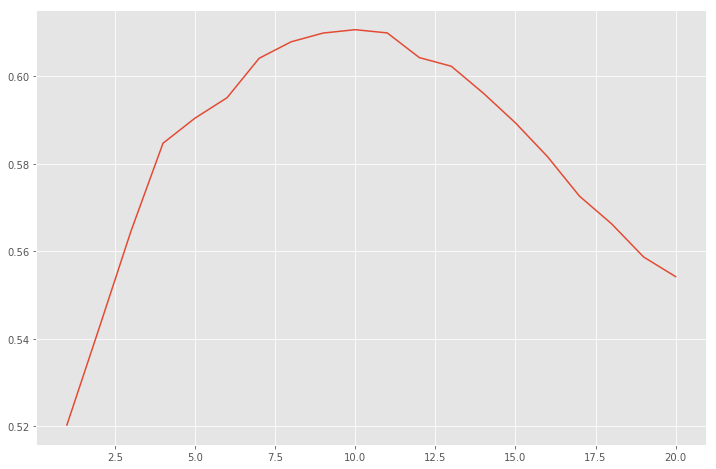

In [17]:
depths = [i for i in range(1, 21)]

rocs = []
for d in depths:
  dtc = DecisionTreeClassifier(max_depth=d, random_state=42)
  dtc.fit(X_train, y_train)
  y_pred = dtc.predict_proba(X_test)
  rocs.append(roc_auc_score(y_test, y_pred[:,1]))
  print(d)
  
plt.plot(depths, rocs)  

Еще я посмотрел на поведение на разном числе естимейторов - я решил использовать градиентный бустинг, потому что он мне понравился, параметры особо не подбирал, поскольку первые модели, но в целом рейт 0.1 и глубина 4 - оптимальные параметры, судя по дальнейшим опытам

      Iter       Train Loss   Remaining Time 
         1           1.0775           37.23s
         2           1.0745           36.50s
         3           1.0721           35.94s
         4           1.0698           35.63s
         5           1.0683           35.17s
         6           1.0667           34.75s
         7           1.0653           34.37s
         8           1.0639           34.20s
         9           1.0628           33.93s
        10           1.0618           34.01s
        20           1.0538           33.56s
        30           1.0494           30.32s
        40           1.0462           26.08s
        50           1.0438           21.43s
        60           1.0416           16.83s
        70           1.0402           12.45s
        80           1.0385            8.27s
        90           1.0372            4.08s
       100           1.0361            0.00s
100
      Iter       Train Loss   Remaining Time 
         1           1.0775            1.36m
    

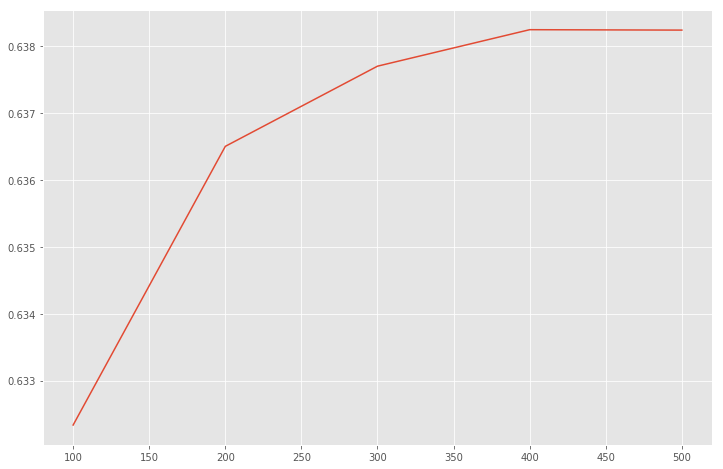

In [0]:
n_estimators = [100 * i for i in range(1, 6)]

rocs = []
for n in n_estimators:
  gdc = GradientBoostingClassifier(n_estimators=n, learning_rate=0.1, max_features=None, subsample=1, verbose=1, max_depth=4, random_state=42)
  gdc.fit(X_train, y_train)
  y_pred = gdc.predict_proba(X_test)
  rocs.append(roc_auc_score(y_test, y_pred[:,1]))
  print(n)
  
plt.plot(n_estimators, rocs)  



Я решил, что хочу, чтобы рок аук на трейне не сильно превосходил рок аук на тесте, поэтому взял 300 естимейторов

In [21]:
gdc = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_features=None, subsample=1, verbose=1, max_depth=4, random_state=42)
gdc.fit(X_train, y_train)
y_pred = gdc.predict_proba(X_test)

      Iter       Train Loss   Remaining Time 
         1           1.0775            1.84m
         2           1.0745            1.79m
         3           1.0721            1.78m
         4           1.0698            1.76m
         5           1.0683            1.75m
         6           1.0667            1.76m
         7           1.0653            1.76m
         8           1.0639            1.77m
         9           1.0628            1.77m
        10           1.0618            1.76m
        20           1.0538            1.80m
        30           1.0494            1.78m
        40           1.0462            1.72m
        50           1.0438            1.66m
        60           1.0416            1.58m
        70           1.0402            1.50m
        80           1.0385            1.44m
        90           1.0372            1.36m
       100           1.0361            1.28m
       200           1.0279           37.23s
       300           1.0225            0.00s


In [22]:
roc_auc_score(y_test, y_pred[:, 1])

0.6377047677026044

In [23]:
roc_auc_score(y_train, gdc.predict_proba(X_train)[:,1])

0.6582486952362904

In [26]:
for i in range(len(X_train.columns)):
  print(X_train.columns[i], gdc.feature_importances_[i])

category_id 0.023370531580080126
delivery_available 0.004127846720447129
img_num 0.009687407716280074
payment_available 0.004860126636358047
price 0.22299810739892012
product_type 0.0006411646237122516
sold_mode 0.004801889536035648
subcategory_id 0.38254361613405485
date_month 0.11159546646317912
date_day 0.08982256993779485
desc_text_length 0.048617835120289894
desc_text_num_of_words 0.014192513389621547
name_text_length 0.03135747531468872
has_properties 0.0016181003423809237
num_properties 0.019490317875138368
size_region 0.030275031211018405


А это уже итоговое обучение для итоговой лучшей модели - если обучение на 0.7 выборки дало 0.61937, то обучение на всей выборке - с увеличенным числом естимейторов - дало 0.621 на паблике.

In [27]:
gdc = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_features=None, subsample=1, verbose=1, max_depth=4, random_state=42)
gdc.fit(X_cleared, y)
y_pred = gdc.predict_proba(X_cleared)


      Iter       Train Loss   Remaining Time 
         1           1.0768            4.16m
         2           1.0738            4.14m
         3           1.0714            4.00m
         4           1.0696            3.99m
         5           1.0678            4.00m
         6           1.0661            3.97m
         7           1.0646            3.98m
         8           1.0632            3.96m
         9           1.0621            3.95m
        10           1.0611            3.95m
        20           1.0533            4.05m
        30           1.0486            3.98m
        40           1.0452            3.89m
        50           1.0429            3.80m
        60           1.0411            3.71m
        70           1.0396            3.59m
        80           1.0384            3.44m
        90           1.0371            3.32m
       100           1.0361            3.21m
       200           1.0291            2.07m
       300           1.0244            1.02m
       40

In [28]:
roc_auc_score(y, y_pred[:, 1])

0.6593639774164943

In [32]:
for i in range(len(X_train.columns)):
  print(X_train.columns[i], gdc.feature_importances_[i])

category_id 0.02732667131925916
delivery_available 0.005484427188824881
img_num 0.011575489368155504
payment_available 0.006315709548266921
price 0.22347449150029444
product_type 0.001278343154464822
sold_mode 0.005549065351604905
subcategory_id 0.375637980415819
date_month 0.11412627955236496
date_day 0.08999703334122827
desc_text_length 0.04585701018440872
desc_text_num_of_words 0.013786703093634431
name_text_length 0.03410505049586351
has_properties 0.0014929192449273944
num_properties 0.017679138327695243
size_region 0.026313687913187972


Как можно заметить, очень важная фича - цена, после нее месяц - ладно, после него - день - неожиданное.. Но на первом месте с большим отрывом - id подкатегории, хотя я все время считал, что он лишь вводит в заблуждение.. Но без него всегда было плохо. Воть так

In [29]:
X_TEST = df_test

columns_with_text = ['city', 'date_created', 'desc_text', 'name_text', 'lat', 'long', 'owner_id', 'product_id', 'properties', 'region']
#X.columns.append(['date_year', 'date_month', 'date_day'])
#X_TEST['date_year'] = X_TEST['date_created'].str[:4].astype(int)
X_TEST['date_month'] = X_TEST['date_created'].str[5:7].astype(int)
X_TEST['date_day'] = X_TEST['date_created'].str[8:10].astype(int)
X_TEST['desc_text_length'] = X_TEST['desc_text'].str.len()
X_TEST['desc_text_num_of_words'] = X_TEST['desc_text'].str.split().map(lambda x: len(x))
X_TEST['name_text_length'] = X_TEST['name_text'].str.len()
X_TEST['has_properties'] = X_TEST['properties'].map(lambda x: len(x) > 2)
X_TEST['num_properties'] = X_TEST['properties'].map(lambda x: x.count('}'))
X_TEST['size_region'] = X_TEST['region'].map(lambda x: regions_mapa[x] if x in regions_mapa.keys() else 0)

X_TEST_CUT = X_TEST.drop(columns=columns_with_text)
X_TEST_CUT.head()

,category_id,delivery_available,img_num,payment_available,price,product_type,sold_mode,subcategory_id,date_month,date_day,desc_text_length,desc_text_num_of_words,name_text_length,has_properties,num_properties,size_region
0,9,True,3,True,650.0,1,1,902,10,22,112,14,9,True,3,9789
3,22,True,2,True,750.0,1,1,2204,11,9,185,28,13,True,6,5148
8,12,False,4,True,5500.0,1,1,1202,11,27,618,99,50,True,13,1211
9,3,True,2,True,100.0,1,1,316,11,25,71,11,17,False,0,76281
19,22,True,2,True,700.0,1,1,2214,11,4,61,10,12,True,5,11476


In [30]:
results = gdc.predict_proba(X_TEST_CUT)[:,1]
results

array([0.17027424, 0.13712656, 0.26574366, ..., 0.20157757, 0.2484418 ,
       0.28702257])

In [0]:
res = pd.DataFrame(columns=['product_id', 'score'], index=None)
res['product_id'] = X_TEST['product_id']
res['score'] = results
res.tail()

res.to_csv('prefinal.csv', index=False)

# Иные подходы и чем я руководствовался

В данном разделе может присутствовать копипаста из других тетрадок и код может воспроизводиться нелинейно, однако моей целью было рассказать о том, что я пытался сделать и к чему это приводило.

Так, я смотрел на разные классификаторы - случайный лес, бэггинг, адабуст, катбуст, xgboost, но они были не очень или чуть хуже

In [0]:
rfc = RandomForestClassifier(n_jobs=4, max_depth=3, max_features=10, n_estimators=500, random_state=42, verbose=1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict_proba(X_test)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   59.3s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    1.6s finished


In [0]:
roc_auc_score(y_test, y_pred[:,1])

0.5903644550470957

In [18]:
abc = BaggingClassifier(verbose=1, n_estimators=100)
abc.fit(X_train, y_train)
y_pred = abc.predict_proba(X_test)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s finished


In [19]:
roc_auc_score(y_test, y_pred[:,1])

0.6003455600824785

Я пробовал нейронки, перед этим используя StandardScaler, но там было совсем грустно, даже на тест было 0.58...


In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout

model = Sequential()
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=256))
model.add(Dropout(0.5))
model.add(Dense(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=64))
model.add(Dense(units=1024))
model.add(Dense(units=1, activation='sigmoid'))

In [0]:
from keras import losses

model.compile(optimizer ='adam',loss=losses.binary_crossentropy)

In [0]:
model.fit(X_train, y_train, batch_size=None, steps_per_epoch=50, epochs=5)
model.summary()

Epoch 1/5
50/50 [==============================] - 13s 255ms/step - loss: 3.7247
Epoch 2/5
26/50 [==============>...............] - ETA: 5s - loss: 3.7247

KeyboardInterrupt: ignored

In [0]:
y_pred = model.predict(X_test)
y_pred

array([[0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       ...,
       [0.0000000e+00],
       [0.0000000e+00],
       [1.2609497e-37]], dtype=float32)

In [0]:
roc_auc_score(y_test, y_pred)

0.4999938369756807

С регионами было по-разному - я хотел выделить большие регионы булевой переменной (легкий one-hot), но оно работало не лучше..

In [0]:
regs = pd.get_dummies(X['region'])
count = len(regs.columns)
bad_cols = []
regs['small_region'] = 0
for col in regs.columns:
  if col is not 'small_region' and len(regs[regs[col] == 1]) < 2 * regs.shape[0] / count:
    bad_cols.append(col)
    regs.small_region[regs[col] == 1] = 1
regs = regs.drop(columns=bad_cols)
new_cols = regs.columns
new_cols

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Index(['Башкортостан', 'Кемеровская область', 'Краснодарский край',
       'Красноярский край', 'Ленинградская область', 'Московская область',
       'Новосибирская область', 'Ростовская область', 'Самарская область',
       'Свердловская область', 'Татарстан', 'Тюменская область',
       'Челябинская область', 'small_region'],
      dtype='object')

## Подход, который  почти смог..

В последний день я с однокурсниками засел в аудитории, и мы пытались улучшить модели. В какой-то момент мне показали график следующего содержания.

In [33]:
sold_fast_proportion = [len(df_train[df_train['date_created'] == day][df_train['sold_fast'] == 1])/len(df_train[df_train['date_created'] == day]) for day in np.unique(df_train['date_created'])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


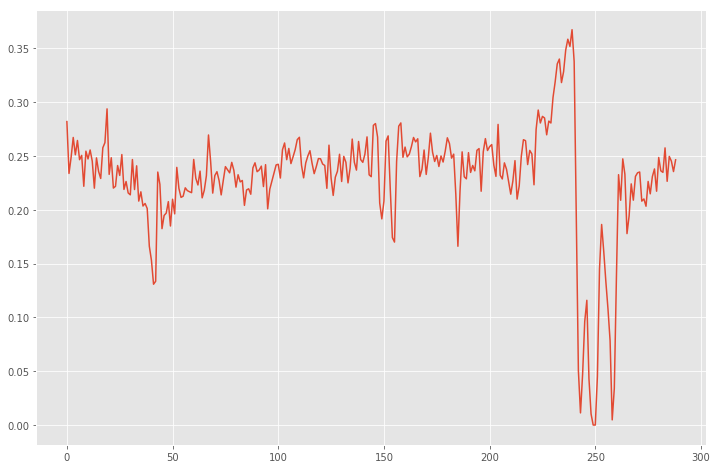

In [34]:
plt.plot(sold_fast_proportion)

Что же это такое? Это доля быстрых продаж в зависимости от дня. И что примечательно - на графике есть явное проседание, примерно в конце августа. Когда я это увидел, я сразу вспомнил возможную причину этого - нет, не сезонный фактор, а падение рубля. С помощью однокурсника мы выгрузили курс доллара за каждый день 2018 года - и вот он:

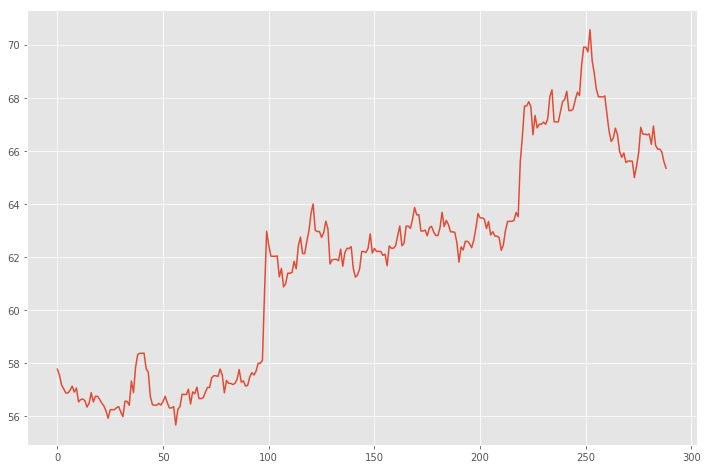

In [36]:
usd_by_day = [57.7656, 57.5336, 57.1698, 57.0156, 56.8703, 56.8703, 56.974, 57.1265, 56.9048, 57.0542, 56.5354, 56.6214, 56.643, 56.5815, 56.34, 56.4806, 56.8843, 56.5337, 56.7449, 56.7449, 56.6259, 56.489, 56.3822, 56.1906, 55.9177, 56.2409, 56.2409, 56.2429, 56.3144, 56.3559, 56.1484, 55.9797, 56.5647, 56.5511, 56.4084, 57.3221, 56.8827, 57.8441, 58.3203, 58.3658, 58.3661, 58.3715, 57.7847, 57.6521, 56.7294, 56.423, 56.4096, 56.4099, 56.48, 56.4139, 56.5566, 56.7465, 56.5016, 56.3072, 56.306, 56.3565, 55.6619, 56.2542, 56.3557, 56.8226, 56.815, 56.8139, 57.013, 56.4534, 56.9132, 56.8434, 57.0927, 56.6576, 56.6576, 56.6927, 56.8929, 57.081, 57.0737, 57.4471, 57.5206, 57.5206, 57.4934, 57.772, 57.5473, 56.8776, 57.3431, 57.2337, 57.2334, 57.189, 57.2315, 57.3856, 57.7538, 57.2778, 57.3279, 57.1326, 57.1511, 57.4729, 57.6332, 57.5481, 57.6937, 57.9894, 57.9908, 58.106, 60.6521, 62.9678, 62.4445, 62.0285, 62.0237, 62.0237, 62.0361, 61.2457, 61.565, 60.8706, 60.9898, 61.3869, 61.3847, 61.4117, 61.8333, 61.5531, 62.4188, 62.7461, 62.1261, 62.1261, 62.5812, 62.9783, 63.6422, 63.9971, 63.0015, 62.9573, 62.9568, 62.7357, 62.9125, 63.3502, 63.061, 61.7336, 61.895, 61.9063, 61.91, 61.8591, 62.2915, 61.6437, 62.1583, 62.322, 62.3199, 62.3846, 61.5664, 61.2374, 61.3206, 61.5515, 62.2049, 62.2052, 62.1689, 62.3258, 62.8688, 62.1446, 62.321, 62.2059, 62.2062, 62.2078, 62.0581, 62.1039, 61.6692, 62.4126, 62.3296, 62.328, 62.4166, 62.8045, 63.1639, 62.4227, 62.5148, 63.1607, 63.1607, 63.0758, 63.4033, 63.8622, 63.5858, 63.5931, 62.9759, 62.9759, 63.0114, 62.7974, 63.0976, 63.1543, 62.9445, 62.808, 62.8058, 63.0883, 63.6822, 63.145, 63.3743, 63.2205, 62.9448, 62.9446, 62.9293, 62.542, 61.8017, 62.3795, 62.2641, 62.5882, 62.5872, 62.5012, 62.3458, 62.6342, 63.0842, 63.6346, 63.4719, 63.4721, 63.4282, 63.0742, 63.3331, 62.8282, 62.9537, 62.7839, 62.7839, 62.7306, 62.2495, 62.4592, 62.9988, 63.3367, 63.342, 63.342, 63.3763, 63.6729, 63.5166, 65.5877, 66.545, 67.6909, 67.6909, 67.8494, 67.6627, 66.6071, 67.3317, 66.8639, 67.0075, 67.0075, 67.0829, 67.0014, 67.2166, 68.0498, 68.2972, 67.0932, 67.0932, 67.093, 67.4703, 67.8484, 67.9424, 68.2452, 67.516, 67.516, 67.578, 67.9144, 68.2069, 68.082, 69.203, 69.9101, 69.9111, 69.7331, 70.5667, 69.4031, 68.9207, 68.3217, 68.0369, 68.0369, 68.0304, 68.0699, 67.3874, 66.748, 66.3572, 66.4793, 66.8534, 66.5978, 65.9817, 65.7536, 65.919, 65.5561, 65.6148, 65.6148, 65.6085, 64.9926, 65.4259, 65.9212, 66.8861, 66.6299, 66.6299, 66.6042, 66.6357, 66.2462, 66.9351, 66.2117, 66.065, 66.065, 65.9475, 65.5768, 65.3444, 65.5591, 65.8092, 65.4973, 65.4973, 65.5465, 65.2115, 65.5191, 65.5916, 65.5776, 65.69, 65.692, 65.685, 65.8128, 65.5094, 65.7482, 65.6843, 66.1583, 66.1583, 66.0966, 66.0613, 66.0585, 66.1885, 66.9001, 67.92, 67.9212, 67.8918, 67.8571, 67.9724, 67.1006, 65.8962, 65.9831, 65.9831, 66.021, 65.5917, 66.0928, 65.6972, 65.6014, 66.2126, 66.2125, 66.5587, 67.1477, 67.0573, 66.9516, 66.1927, 67.0572, 67.0545, 66.7415, 66.5852, 66.8281, 66.5218, 66.7492, 66.4191, 66.4191, 66.4347, 66.6824, 66.4127, 66.4137, 66.3483, 66.8249, 66.8249, 66.681, 66.654, 67.4666, 67.4527, 68.2993, 68.89, 68.8903, 68.7537, 68.6487, 68.7465, 68.7911, 69.591, 69.5009, 69.5009, 69.5234, 69.2062]  
plt.plot(usd_by_day[:len(np.unique(df_train['date_created']))])

Как я вижу сейчас, это не совсем верно все же, но в меня засела мысль приписать в модели курс доллара и посмотреть что выйдет. На локальном обучении и валидации выходило неплохо, был прирост, но на паблик лидерборде скор был 0.54 - и я увидел объяснение этому в том, что большую роль при обучении модели стал играть курс доллара - а тестируемый датасет периодом не пересекается с тренировочным (второй по 16 октярбя, первый с 17 октября, кажется), и в октябре курс доллара был выше, чем весь остальной год - и это могло склонять модель к предсказывании непродажи товара.. Но я пытался и не жалею

In [0]:
days = list(np.unique(df_train['date_created'])) + list(np.unique(df_test['date_created']))
mapa_usd_day = {}
mapa_delta_usd_day = {}
mapa_day_of_week = {}
for i in range(len(days)):
  mapa_usd_day[days[i]] = usd_by_day[i]
  if i == 0:
    mapa_delta_usd_day[days[i]] = 0
  else:
    mapa_delta_usd_day[days[i]] = usd_by_day[i] - usd_by_day[i-1]
  mapa_day_of_week[days[i]] = i % 7  

Также я решил добавить день недели, дельту курса доллара с предыдущим днем, сезон (ориентируясь на температуру и свои ожидания), номер непосредственно подкатегории, раз оно хорошо работало, поиск нескольких слов в тексте описани, медианную цену товара в даной субкатегории и отношении ценыданного товара к этой медиане - в моделях эти две фичи суммарно набирали важность 0.2! 

In [0]:
import json

def prepareX(X):
  columns_with_text = ['city', 'date_created', 'desc_text', 'name_text', 'lat', 'long', 'owner_id', 'product_id', 'properties', 'region', 'category_id', 'date_month']
  X_prep = X.copy()
  X_prep['date_month'] = X['date_created'].str[5:7].astype(int)
  seasons = {1:4, 2:4, 3:3.5, 4:3, 5:2.5, 6:1, 7:1, 8:1, 9:2.5, 10:2.5, 11:3.3, 12:4}
  X_prep['season'] = X_prep['date_month'].map(lambda x: seasons[x])
  usd_by_month = [56.4981,56.8067,57.0636,60.7699,62.2309,62.7685,62.8619,66.0764,67.6661,65.8545,66.3557,67.3353]
  X_prep['mean_usd_in_month'] = X_prep['date_month'].map(lambda x: usd_by_month[x-1])
  X_prep['usd_course'] = X_prep['date_created'].map(lambda x: mapa_usd_day[x])
  X_prep['usd_course_delta'] = X_prep['date_created'].map(lambda x: mapa_delta_usd_day[x])
  X_prep['day_of_week'] = X_prep['date_created'].map(lambda x: mapa_day_of_week[x])
  X_prep['subcategory'] = X_prep['subcategory_id'].map(lambda x: x % 100)
  
  X_prep['desc_text_length'] = X['desc_text'].str.len()
  X_prep['desc_text_num_of_words'] = X['desc_text'].str.split().map(lambda x: len(x))
  X_prep['name_text_length'] = X['name_text'].str.len()
  #X_prep['has_properties'] = X['properties'].map(lambda x: len(x) > 2)
  X_prep['num_properties'] = X['properties'].map(lambda x: x.count('}'))
  X_prep['asap'] = X['desc_text'].str.lower().str.find('срочно') > -1
  X_prep['free'] = X['desc_text'].str.lower().str.find('бесплатн') > -1
  X_prep['cheap'] = X['desc_text'].str.lower().str.find('недорог') > -1
  X_prep['sale'] = X['desc_text'].str.lower().str.find('скидк') > -1
  X_prep['gift'] = X['desc_text'].str.lower().str.find('подарок') > -1
  X_prep['new'] = X['desc_text'].str.lower().str.find('новый') > -1
  X_prep['new2'] = X['desc_text'].str.lower().str.find('новая') > -1
  X_prep['loud'] = X['desc_text'].str.find('!') > -1
  meds = {}
  for cat in np.unique(X_prep['subcategory_id']):
    meds[cat] = np.median(X_prep[X_prep['subcategory_id'] == cat]['price'])
                         
  X_prep['med_subcat'] = X_prep['subcategory_id'].map(lambda x: meds[x] if meds[x] > 0 else 1)
  X_prep['price_comp_subcat'] = X_prep['price'] / X_prep['med_subcat']
  X_prep = X_prep.drop(columns=columns_with_text)
  return X_prep

"\ndef prepareX(X):\n  columns_with_text = ['city', 'date_created', 'desc_text', 'name_text', 'lat', 'long', 'owner_id', 'product_id', 'properties', 'region']\n  X_prep = X.copy()\n  #X.columns.append(['date_year', 'date_month', 'date_day'])\n  #X_prep['date_year'] = X['date_created'].str[:4].astype(int)\n  X_prep['date_month'] = X['date_created'].str[5:7].astype(int)\n  X_prep['date_day'] = X['date_created'].str[8:10].astype(int)\n  X_prep['desc_text_length'] = X['desc_text'].str.len()\n  X_prep['desc_text_num_of_words'] = X['desc_text'].str.split().map(lambda x: len(x))\n  X_prep['name_text_length'] = X['name_text'].str.len()\n  X_prep['has_properties'] = X['properties'].map(lambda x: len(x) > 2)\n  X_prep['num_properties'] = X['properties'].map(lambda x: x.count('}'))\n \n  #regions = {}\n  #for i, reg in enumerate(set(X_prep['region'])):\n  #  regions[reg] = i\n  regs = pd.get_dummies(X_prep['region'])\n  count = len(regs.columns)\n  bad_cols = []\n  regs['size_region'] = 0\n  for 

In [0]:
from sklearn.metrics import classification_report

for col in X_train.columns:
  if (len(np.unique(X_train[col])) == 2):
    print(col)
    print(classification_report(X_train[col], y_train))

delivery_available
              precision    recall  f1-score   support

       False       0.67      0.77      0.72     94068
        True       0.33      0.23      0.27     46444

    accuracy                           0.59    140512
   macro avg       0.50      0.50      0.49    140512
weighted avg       0.56      0.59      0.57    140512

payment_available
              precision    recall  f1-score   support

       False       0.40      0.77      0.53     56511
        True       0.60      0.23      0.33     84001

    accuracy                           0.45    140512
   macro avg       0.50      0.50      0.43    140512
weighted avg       0.52      0.45      0.41    140512

product_type
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.99      0.23      0.37    137657
           5       0.00      0.00      0.00      2855

    accuracy                           0.23    140512
   macro avg       0.33 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.99      0.23      0.37    139014
           2       0.00      0.00      0.00      1498

    accuracy                           0.23    140512
   macro avg       0.33      0.08      0.12    140512
weighted avg       0.98      0.23      0.37    140512

asap
              precision    recall  f1-score   support

       False       0.97      0.77      0.86    136133
        True       0.04      0.29      0.07      4379

    accuracy                           0.76    140512
   macro avg       0.51      0.53      0.46    140512
weighted avg       0.94      0.76      0.84    140512

free
              precision    recall  f1-score   support

       False       0.99      0.77      0.87    138439
        True       0.02      0.32      0.04      2073

    accuracy                           0.77    140512
   macro avg       0.50      0.55      0.45    140512
weighted a

Я проводил разные эксперименты, удаляя разные признаки, и в целом было неплохо, вот пример эксперимента по подгону гиперпараметров

Est: 100 max_features: 3 rate: 0.2 depth: 2


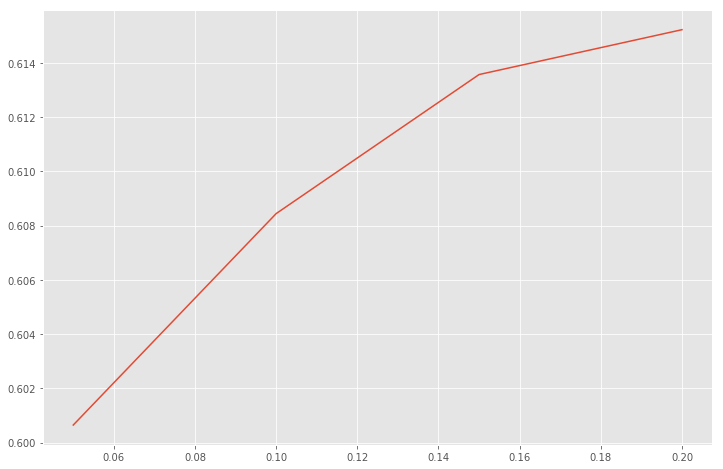

Est: 100 max_features: 6 rate: 0.2 depth: 2


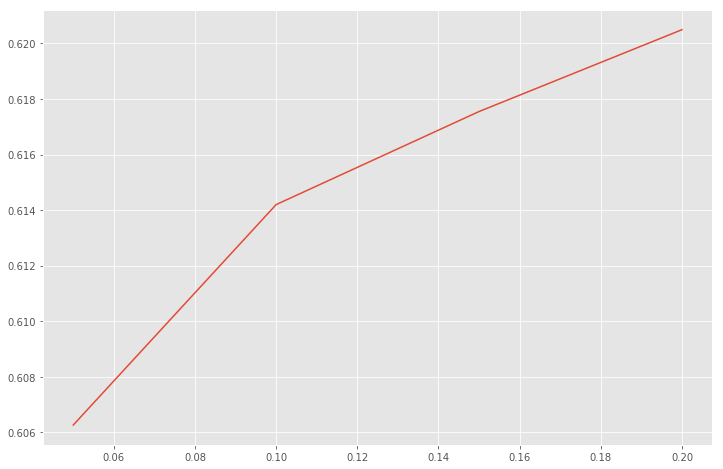

Est: 100 max_features: 9 rate: 0.2 depth: 2


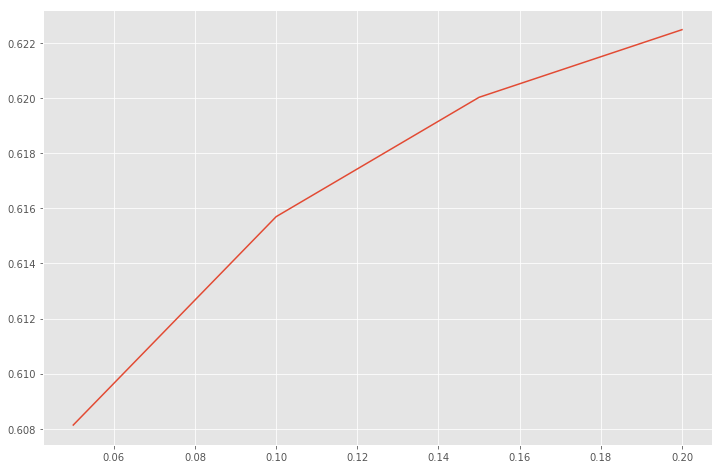

Est: 100 max_features: 3 rate: 0.2 depth: 4


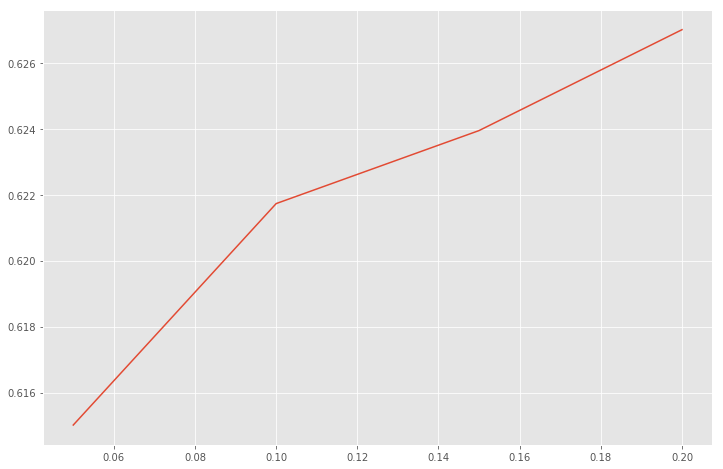

Est: 100 max_features: 6 rate: 0.2 depth: 4


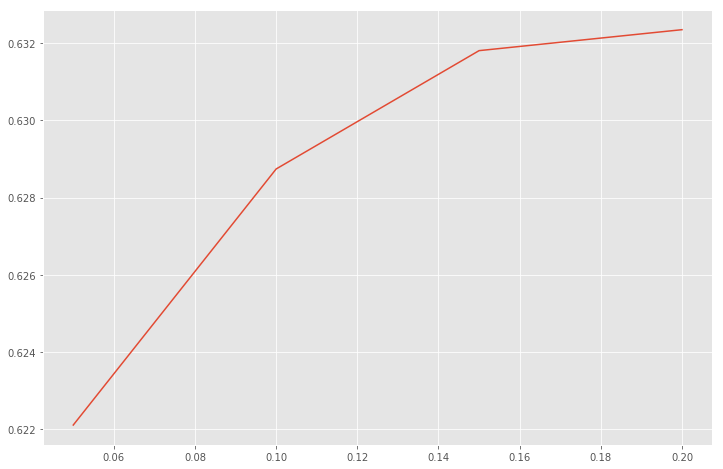

Est: 100 max_features: 9 rate: 0.2 depth: 4


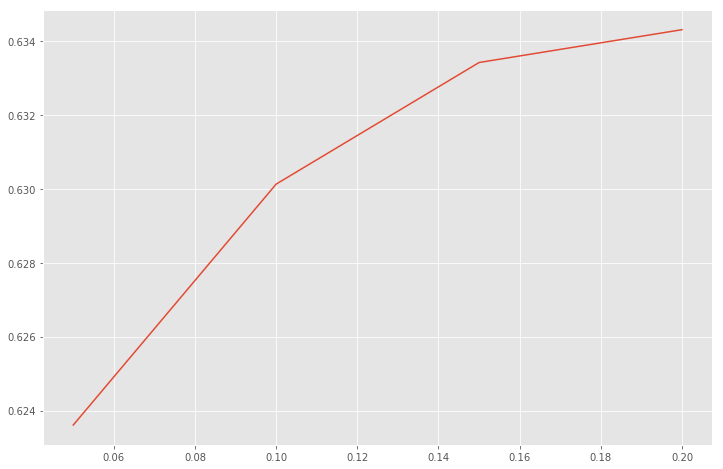

Est: 100 max_features: 3 rate: 0.2 depth: 6


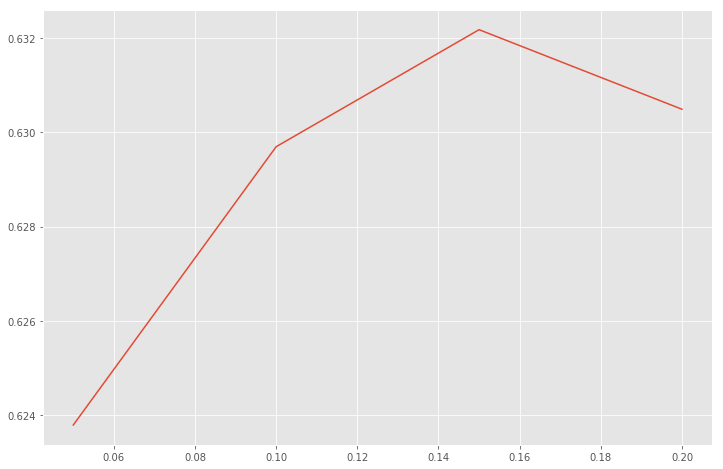

Est: 100 max_features: 6 rate: 0.2 depth: 6


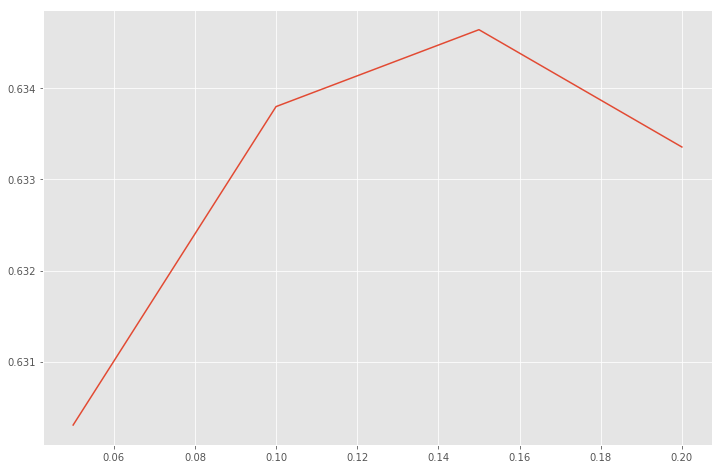

Est: 100 max_features: 9 rate: 0.2 depth: 6


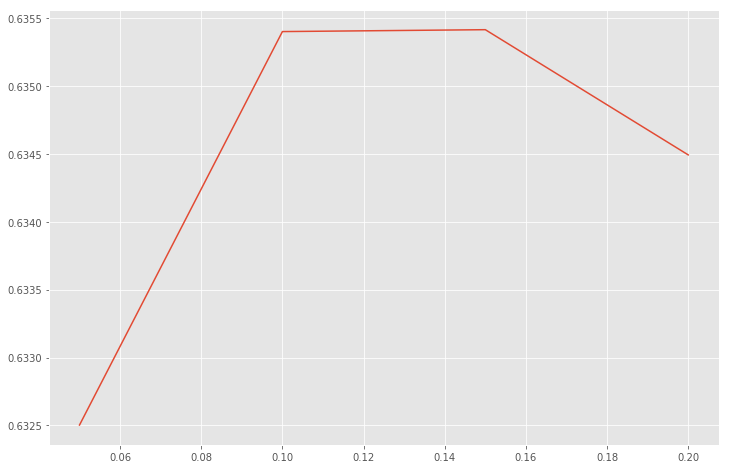

In [0]:
n_estimators = [100 * i for i in range(1, 2)]
lr = [0.05 * i for i in range(1, 5)]
max_features = [3 * i for i in range(1, 4)]
depth = [2*i for i in range(1, 4)]

rocs = []
for n in n_estimators:
  for d in depth:
    for feat in max_features:
      rocs = []
      for rate in lr:
        gdc = GradientBoostingClassifier(n_estimators=n, learning_rate=rate, max_features=feat, subsample=1, verbose=0, max_depth=d, random_state=42)
        gdc.fit(X_train, y_train)
        y_pred = gdc.predict_proba(X_test)
        rocs.append(roc_auc_score(y_test, y_pred[:,1]))
      print('Est:', n, 'max_features:', feat, 'rate:', rate, 'depth:', d)
      plt.plot(lr, rocs)  
      plt.show()



Также я хотел, чтобы скоры на трейне и тесте были близки - и проверял и это начиная с какого-то момента

      Iter       Train Loss   Remaining Time 
         1           1.0749            2.19s
         2           1.0715            2.38s
         3           1.0682            2.33s
         4           1.0664            2.11s
         5           1.0639            1.97s
         6           1.0622            1.83s
         7           1.0602            1.72s
         8           1.0587            1.61s
         9           1.0570            1.50s
        10           1.0556            1.37s
        20           1.0471            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.0749            5.16s
         2           1.0715            5.15s
         3           1.0682            5.15s
         4           1.0664            4.80s
         5           1.0639            4.65s
         6           1.0622            4.51s
         7           1.0602            4.43s
         8           1.0587            4.35s
         9           1.0570            4.28s
        

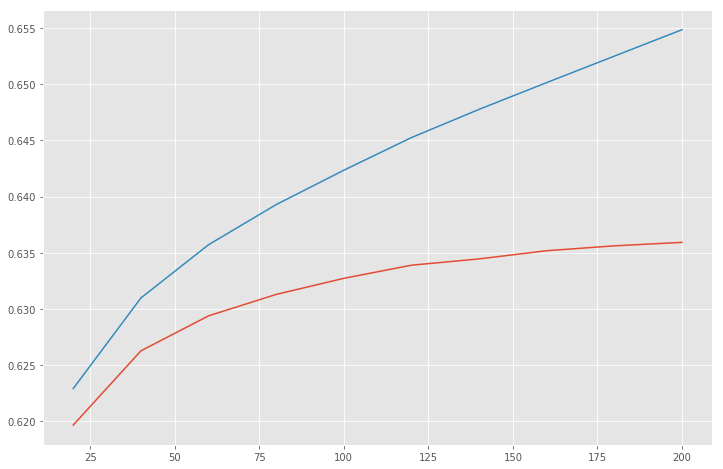

In [0]:
n_est = [20*i for i in range(1, 11)]
rocs = []
rocs_train = []
gdc = GradientBoostingClassifier()
for n in n_est:
  gdc = GradientBoostingClassifier(n_estimators=n, learning_rate=0.1, max_features=6, subsample=1, verbose=1, max_depth=4, random_state=42,
                                  min_impurity_decrease=0.1)
  gdc.fit(X_train, y_train)
  y_pred = gdc.predict_proba(X_test)
  y_pred_train = gdc.predict_proba(X_train)
  rocs.append(roc_auc_score(y_test, y_pred[:, 1]))
  rocs_train.append(roc_auc_score(y_train, y_pred_train[:, 1]))
  
plt.plot(n_est, rocs) 
plt.plot(n_est, rocs_train)  
  

В итоге лучшим решением в последние дни стала комбинация градиентного бустинга и xgboost

In [0]:
import json

def prepareX(X):
  columns_with_text = ['city', 'date_created', 'desc_text', 'name_text', 'lat', 'long', 'owner_id', 'product_id', 'properties', 'region', 'category_id']
  X_prep = X.copy()
  X_prep['date_month'] = X['date_created'].str[5:7].astype(int)
  X_prep['desc_text_length'] = X['desc_text'].str.len()
  X_prep['desc_text_num_of_words'] = X['desc_text'].str.split().map(lambda x: len(x))
  X_prep['name_text_length'] = X['name_text'].str.len()
  X_prep['has_properties'] = X['properties'].map(lambda x: len(x) > 2)
  X_prep['num_properties'] = X['properties'].map(lambda x: x.count('}'))
  X_prep['asap'] = X['desc_text'].str.lower().str.find('срочно') > -1
  X_prep['loud'] = X['desc_text'].str.find('!') > -1
  meds = {}
  for cat in np.unique(X_prep['subcategory_id']):
    meds[cat] = np.median(X_prep[X_prep['subcategory_id'] == cat]['price'])
                         
  X_prep['med_subcat'] = X_prep['subcategory_id'].map(lambda x: meds[x] if meds[x] > 0 else 1)
  X_prep['price_comp_subcat'] = X_prep['price'] / X_prep['med_subcat'] 
  X_prep = X_prep.drop(columns=columns_with_text)
  return X_prep

In [0]:
gdc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_features=None, subsample=1, verbose=1, max_depth=4, random_state=42)
gdc.fit(X_train, y_train)
y_pred = gdc.predict_proba(X_test)

      Iter       Train Loss   Remaining Time 
         1           1.0734           38.97s
         2           1.0698           37.32s
         3           1.0669           37.16s
         4           1.0641           37.17s
         5           1.0620           36.36s
         6           1.0601           37.31s
         7           1.0586           37.11s
         8           1.0571           37.40s
         9           1.0558           37.62s
        10           1.0547           37.47s
        20           1.0474           34.97s
        30           1.0434           32.63s
        40           1.0407           30.37s
        50           1.0389           28.05s
        60           1.0373           25.92s
        70           1.0359           23.96s
        80           1.0347           21.87s
        90           1.0335           19.82s
       100           1.0323           17.77s
       200           1.0229            0.00s


In [0]:
roc_auc_score(y_test, y_pred[:, 1])

0.6269417302738292

In [0]:
from xgboost import XGBClassifier


xgb = XGBClassifier(n_estimators=150, max_depth=4, learning_rate=0.15, n_jobs=5, verbosity=1, random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict_proba(X_test)

In [0]:
roc_auc_score(y_test, y_pred[:, 1])

0.6273876262207247

In [0]:
gdc = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_features=None, subsample=1, verbose=1, max_depth=4, random_state=42)
gdc.fit(X, y)
y_pred1 = gdc.predict_proba(X)
xgb = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.15, n_jobs=5, verbosity=1)
xgb.fit(X, y)
y_pred2 = xgb.predict_proba(X)
y_pred = (y_pred1 + y_pred2) / 2

      Iter       Train Loss   Remaining Time 
         1           1.0763            3.33m
         2           1.0728            3.24m
         3           1.0699            3.26m
         4           1.0675            3.24m
         5           1.0651            3.27m
         6           1.0635            3.25m
         7           1.0618            3.24m
         8           1.0603            3.25m
         9           1.0592            3.26m
        10           1.0580            3.24m
        20           1.0510            3.14m
        30           1.0472            3.03m
        40           1.0449            2.90m
        50           1.0435            2.79m
        60           1.0421            2.65m
        70           1.0411            2.53m
        80           1.0400            2.40m
        90           1.0393            2.26m
       100           1.0385            2.13m
       200           1.0330            1.01m
       300           1.0291            0.00s


In [0]:
roc_auc_score(y, y_pred[:,1])

0.6486425273319752

В приведенном коде итоговая модель обучается уже на всей выборке, в по отдельности обучалось на 0.4 от тренировочного датасета. Прирост рок аука для теста от усреднения предсказаний составлял несколько тысячных - глядя на лидерборд, это много:)

# Model interpretation
Try to interpret your model results
* What **knowledge** does it reveal?

В итоге получилось, что большую роль играют цена, месяц и подкатегория. Вот прям никуда без них.

Я почти не работал с текстами, поскольку посчитал, что они не дадут мне буста - и редкие попытки либо рушили ядро, либо не давали прирост. 

Я постарался идти довольно простым и понятным путем и, надеюсь, ничего не забыл в описании своих размышлений.

Наверно, стоило попробовать линейный классификатор или обучать модель подольше, но на первое не осталось попыток, когда мне это стукнуло в голову, а второе я боялся делать (а еще в связи с этим я в последние дни обучался на 0.3-0.5 от выборки, а не на 0.7 - рок аук на тесте падал сравнительно значительно,но в кегле результат выходил не столь плохим, то есть локальный рок аук становился репрезентативнее),  о чем, возможно, сожалею. 

А с курсом доллара было интересно... Была идея пронормировать его для тестового сета, поскольку там курс был сам по себе стабилен, или получше прописать в фичах динамику, но не осталось времени и попыток, да и понимания четкого не было. Но мне кажется, что некоторая зависимость все же может присутствовать. Тем более на тренировочном сете же дает буст)) Просто предсказывать на пару дней вперед мы бы, возможно, смогли, но на пару месяцев - оказалось слишком сложно.

Кажется, все..

Ну и да, гиперпараметры подставлялись методом проб и ошибок, а также на личном понимании того, что происходит, иногда я рисовал графички, но сейчас их затруднительно найти.

Пересмотрел таблички
Широта и долгота оказались нерепрезентативны, а идея заменить регион или город на его население не дошла до кода. Идея заменять на вероятность sold_fast == 1 мне просто не особо понятна (понятно почему, не понятно, зачем и почему должно прям хорошо работать) и не нравится. owner_id можно было бы использовать, но из 350к записей 300к разных оунеров - кажется, не сильно влияет, хотя кто знает..  А еще продукт тайп можно было кикать, он часто давал нулевую значимость) 
Вот теперь, кажется, точно все:)

Было интересно, жаль, результаты вышли не самые лучшие, но для своего KISS подхода - я рад, что перебил 0.62 на кегле :)